## Разведочный анализ данных задачи определения популярности геолокации для размещения банкомата
### 1. Описание признаков
- id_0 - порядковый номер в полученном датасете 
- id - предположительно, порядковый номер в исходном датасете, который потом был разбит на части, одной из которых стал полученный нами датасет
- atm_group - банковская группа, которой принадлежит банкомат
- address - адрес банкомата в транслитерации
- addres_rus - адрес банкомата на русском
- lat, long - широта и долгота, координаты расположения банкомата на карте 
- target - целевая переменная, индекс популярности места для расположения банкомата
- элементы адреса, полученны в результате анализа исходного адреса или координат банкомата: 
    - federal_district - федеральный округ РФ
    - region_with_type - субъект РФ
    - area_with_type - муниципальный район или городской округ в составе субъекта РФ
    - city_with_type - город
    - city_area - административный округ города (для г.Москва)
    - city_district_with_type - район города
    - settlement_with_type - сельское поселение (в составе муниципального района или городского округа)
    - street_with_type - улица
    - house - номер дома
- capital_marker - признак столицы региона или города федерального значения
    - 1 — центр района (Московская обл, Одинцовский р-н, г Одинцово)
    - 2 — центр региона (Новосибирская обл, г Новосибирск)
    - 3 — центр района и региона (Томская обл, г Томск)
    - 4 — центральный район региона (Тюменская обл, Тюменский р-н)
    - 0 — ничего из перечисленного (Московская обл, г Балашиха)
- данные о ближайших станциях и линиях метро: 
    - nearest_metro_distance - расстояние до ближайшего метро
    - metro_station_name_{N}, metro_line_name_{N}, metro_distance_{N} - наименование станции, ветки и расстояния до станции метро N (N - не более 3)
- locality_area - площадь города, в котором расположен банкомат (в кв.км)
- locality_population - население города, в котором расположен банкомат (количество человек)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('datasets/train.csv')
df.head(5)

,id_0,id,atm_group,address,address_rus,lat,long,target,federal_district,region_with_type,...,metro_line_name_1,metro_distance_1,metro_station_name_2,metro_line_name_2,metro_distance_2,metro_station_name_3,metro_line_name_3,metro_distance_3,locality_area,locality_population
0,2606,5.0,496.5,BUDENNOGO 7A ELISTA,"улица С.М. Будённого, 7А, Элиста, Республика К...",46.318213,44.260407,0.019958,Южный,Респ Калмыкия,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.376920,103122.0
1,2607,6.0,496.5,"HO CHI MIHN AVE, 19 ULYANOVSK","г Ульяновск, пр-кт Хо Ши Мина, д 19",54.270398,48.300632,-0.089111,Приволжский,Ульяновская обл,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,326.723424,627705.0
2,5126,7.0,496.5,SHELESTA 116A KHABAROVSK,"улица Шелеста, 116А, Хабаровск, Россия, 680042",48.520503,135.052576,-0.048769,Дальневосточный,Хабаровский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.085968,616372.0
3,2608,8.0,496.5,ORDZHONIKIDZE 52 YAKUTSK,"улица Орджоникидзе, 52, Якутск, Республика Сах...",62.025583,129.721362,-0.041545,Дальневосточный,Респ Саха /Якутия/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.141162,322987.0
4,2609,10.0,496.5,"VETERANOV AVE, 3 KRASNOKAMENS","проспект Ветеранов, 11, Краснокаменск, Забайка...",50.089050,118.027310,0.025479,Дальневосточный,Забайкальский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.359358,51387.0


In [5]:
df.shape

(6261, 30)

Проанализируем значения признаков в датасете, разбив их на три группы:
- **группа 1** - признаки, которые были в исходном датасете (кроме адреса банкомата), а также площадь и население города
- **группа 2** -признаки с адресом банкомата и его составляющими
- **группа 3** -признаки с данными о ближайших станциях метро

### 2. Анализ признаков первой группы: координаты банкомата, банковская группа, население и площадь города расположения, целевая переменная

Сформируем датафрейм с указанными столбцами и выполним его анализ 

In [2]:
gr1_col_list = ['atm_group', 'lat', 'long', 'target', 'capital_marker', 'locality_area', 'locality_population']  
df1 = df[gr1_col_list]
description = df1.describe(include='all')
description['locality_population'] = description['locality_population'].apply("{0:.5f}".format)
description['locality_area'] = description['locality_area'].apply("{0:.5f}".format)
description

,atm_group,lat,long,target,capital_marker,locality_area,locality_population
count,6261.000000,6260.000000,6260.000000,6261.000000,6218.000000,6172.00000,6172.00000
mean,4417.937230,54.177808,63.153944,0.000715,1.188807,10028.66557,2001685.05379
std,2430.413287,4.343197,32.939316,0.085852,0.932527,117529.06322,3747912.09215
min,32.000000,42.057080,19.941530,-0.145001,0.000000,0.00000,0.00000
25%,1942.000000,52.259965,37.768561,-0.061176,0.000000,75.59791,200636.00000
50%,5478.000000,55.112968,48.396165,-0.015573,2.000000,240.72413,576624.00000
75%,5478.000000,56.122756,84.944037,0.040149,2.000000,504.61807,1156659.00000
max,8083.000000,69.491912,173.706490,0.218608,4.000000,3233241.98836,12678079.00000


По результатам описания параметров можно предварительно сделать следующие заключения: 
- в столбцах atm_group и target пропусков нет
- в столбцах lat и lon пропущено одно значение (видимо, для одного банкомата отсутствуют координаты)
- в столбцах locality_area и locality_population: 
  - есть ~ 100 пропусков
  - есть нулевые значения, что не очень логично, т.к. население и площадь населенного пункта не могут быть нулевой
  - максимальное значение количества населения выглядит правдоподобно (очевидно, это Москва с ее ~ 12 милионным населением), а вот максимальная площад в ~3 миллиона кв.км. не очень похожа на площадь города и требует отдельного внимания

Поля capital_marker и atm_group, хоть и численные, на самом деле являются категориальными признаками, на что мы подробнее посмотрим ниже.

Проведем дополнительные анализ указанных признаков

#### 2.1. Банковская группа (atm_group)

In [12]:
df1['atm_group'].unique()

array([ 496.5, 1022. ,   32. , 1942. , 3185.5, 8083. , 5478. ])

Взяв уникальные значения признака, видим, что их всего 7 штук. Видимо, это числовые представления каких-то банков или групп банков, к которым относятся банкоматы. Построим гистограмму, показывающую количество банкоматов каждой группы в выборке.

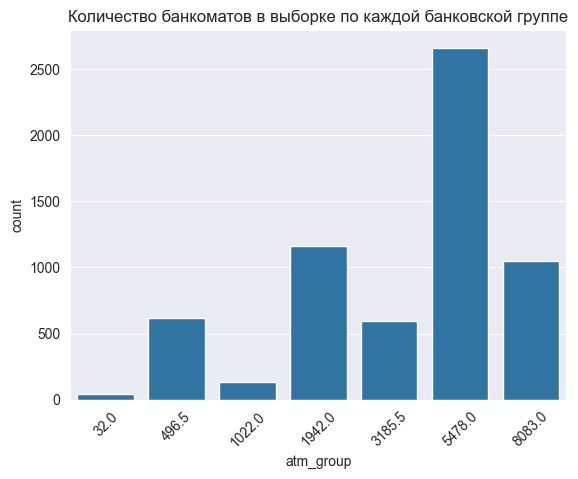

In [15]:
sns.countplot(data=df1, x='atm_group')
plt.xticks(rotation=45)
plt.title('Количество банкоматов в выборке по каждой банковской группе')
plt.show()

Видим, что количество данных о бакоматах для каждой группы неодинаково. 

#### 2.2. Координаты банкомата
Посмотрим на распределения координат банкомата

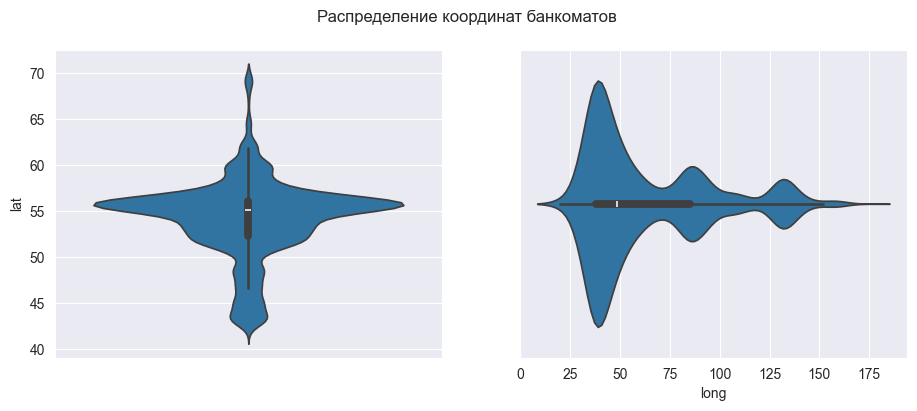

In [31]:
fig, ax1= plt.subplots(1, 2, figsize= (11, 4))
sns.violinplot(y="lat", data= df1, ax= ax1[0])
plt.suptitle("Распределение координат банкоматов")
sns.violinplot(x="long", data= df1, ax= ax1[1])
plt.show()

Видим, что основные значения широты находятся в окрестности 55, а основные значения долготы в окрестносях 30, 80 и 130, что примерно соответствует расположениею основных населенных пунктов на территории РФ

К сожалению, значения координат не являются мерой какой-либо характеристики банкомата и просто отражают его местоположения на карте, поэтому вряд ли могут быть полезны в линейных моделях 

#### 2.3. Уровень населенного пункта (capital_marker)
Как и atm_group, capital_marker на самом деле является категориальным признаком с возможными значениями от 0 до 4. Посмотрим количество банкоматов в выборки в зависимости от этого признака.  

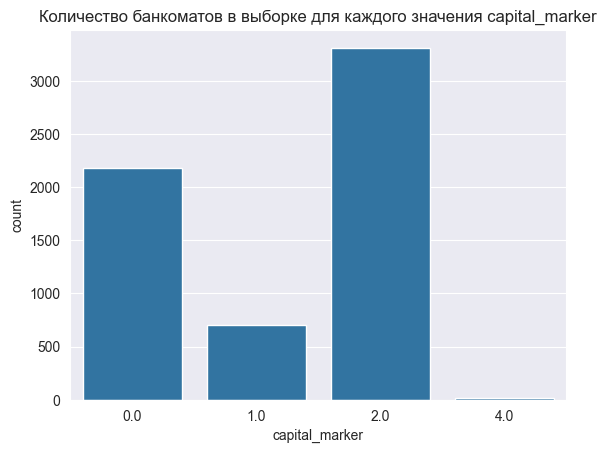

In [23]:
sns.countplot(data=df1, x='capital_marker')
plt.title('Количество банкоматов в выборке для каждого значения capital_marker')
plt.show()

Видим, что распределение количества банкоматов в выборке по значениям признака неравномерно. Основная часть записей приходится на значения 0, 1 и 2. А максимум - на 2. 
Можно предположить, что целевая переменная зависит от данного признака, т.к. он говорит о том, насколько велик город и каков его статус. Посмотрим на эту взаимосвязь чуть ниже 


#### 2.4. Площадь и население города расположения банкомата (locality_area и locality_population)
Посмотрим на распределение признаков 

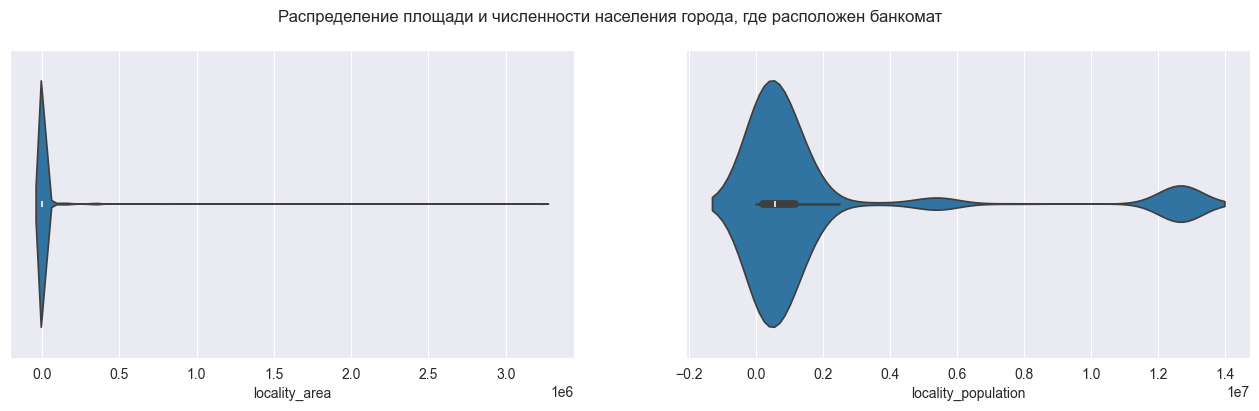

In [42]:
fig, ax1= plt.subplots(1, 2, figsize= (16, 4))
sns.violinplot(x="locality_area", data= df1, ax= ax1[0])
plt.suptitle("Распределение площади и численности населения города, где расположен банкомат")
sns.violinplot(x="locality_population", data= df1, ax= ax1[1])
plt.show()

Распределение населения в целом реалистично: мы видим, что основная часть данных приходятся города с численностью населения до 1 миллиона человек. Кроме того, мы видим два всплеска на отметках ~ 5 млн.чел. (это Санкт-Петербург) и ~12 млн.чел. (это Москва)

А вот распределение площади выглядит странным. Скорее всего, это связано с наличием в данных значений площади, не соответствующих площади городов. Учитывая, что самый большой город в РФ - это Москва (~ 2500 кв.вм), построим распределение значений признака, убрав из них значения, превышающие 3000 кв.км.

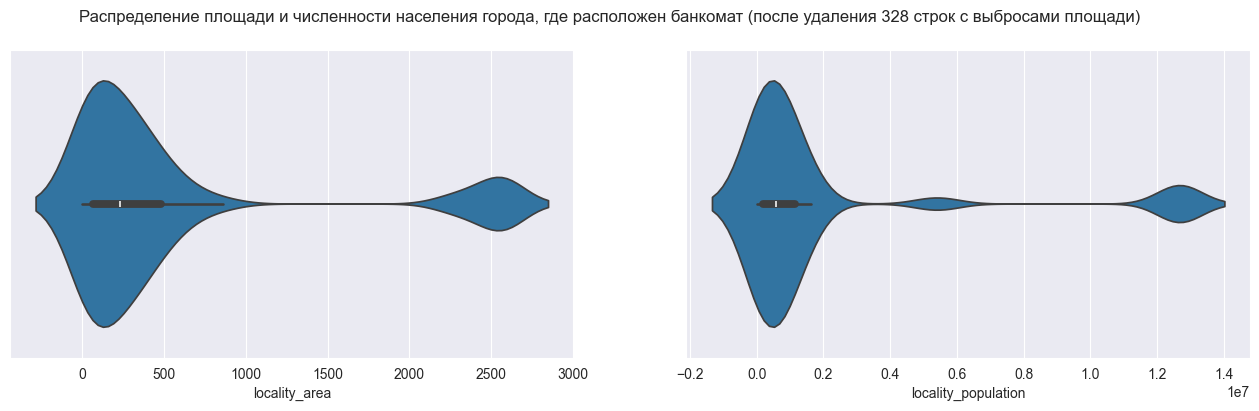

In [56]:
cleaned_by_locality_area = df1[df1['locality_area'] < 3000] 
deleted_row_count = df1.shape[0] - cleaned_by_locality_area.shape[0]
fig, ax1= plt.subplots(1, 2, figsize= (16, 4))
sns.violinplot(x="locality_area", data= cleaned_by_locality_area, ax= ax1[0])
plt.suptitle(f"Распределение площади и численности населения города, где расположен банкомат "
             f"(после удаления {deleted_row_count} строк с выбросами площади)")
sns.violinplot(x="locality_population", data= cleaned_by_locality_area, ax= ax1[1])
plt.show()

Видим, что после удаления строк, для которых площадь населенного пункта была больше 3000 кв.м. (таких строк - 328) распределение площади стало более правдоподобным

Также выше мы указывали, что в выборке есть записи и с нулевым значением площади и численности населения. Посмотрим, сколько таких записей. 

In [54]:
print('Количество строк с нулевой площадью: ', df1[df1['locality_area'] == 0].shape[0])
print('Количество строк с нулевой численностью населения: ', df1[df1['locality_population'] == 0].shape[0])

Количество строк с нулевой площадью:  470
Количество строк с нулевой численностью населения:  5


Видим, что в данных определенное количество ошибочных значений (328 аномально больших и 470 нулевых площадей; 5 значений с 0 в качестве численности населения). Причинами таких данных может быть: 
- отсутствие данных о численности населения и площади населенного пункта в сервисе, используемом для получения этих данных. В этом случае можно попытаться найти и заполнить значения вручную. 
- получение данных о площади и численности населения не для населенного пункта, а, например, для региона, в котором он находится. В этом случае нужно поискать неточности в работе алгоритма наполнения данными. 

#### 2.5. Целевая переменная (target)
Посмотрим на распределение целевой переменной

In [59]:
df['target'].describe()

count    6261.000000
mean        0.000715
std         0.085852
min        -0.145001
25%        -0.061176
50%        -0.015573
75%         0.040149
max         0.218608
Name: target, dtype: float64

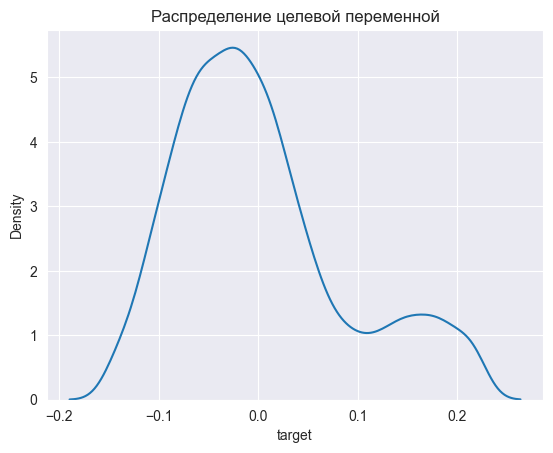

In [61]:
sns.kdeplot(x="target", data= df1, )
plt.title("Распределение целевой переменной")
plt.show()

#### 2.6. Анализ зависимостей признаков
Вычислим попарные коэффициенты корреляции признаков и отобразим их на диаграмме

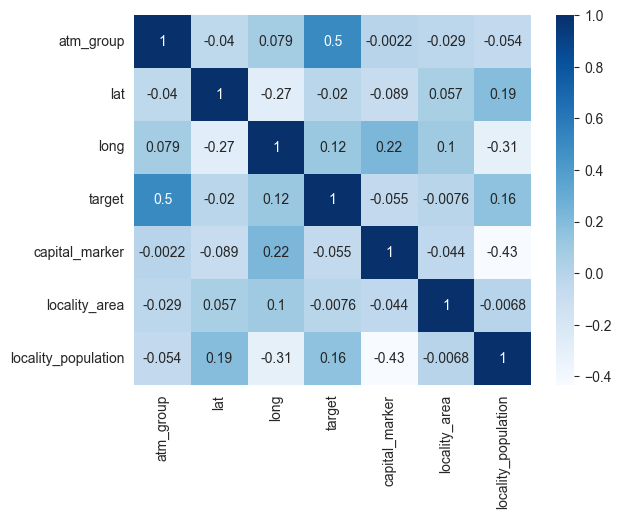

In [10]:
sns.heatmap(df1.corr(), cmap="Blues", annot=True)
plt.show()

На основе полученных значений можно заметить, что: 
- коэффициент корреляции между целевой переменной и признаком atm_group равен 0.5. И хотя atm_group по сути категориальный признак, его значение может отражать какую-то характеристику банковской группы и, соответственно, влиять на значение целевой переменно. Можно предположить, что значение признака atm_group можно будет использовать при реализации моделей машинного обучения;
- целевой коэффициент также может иметь некоторую зависимость от признака locality_population, что может быть связано с тем, что в густонаселенных городах банкоматы пользуются чуть большей популярностью; 
- целевой коэффициент также может иметь зависимость от признака long, которую трудно объяснить

Кроме того: 
- наблюдается зависимость признаков lat и long, которая может объясняться особенностью расположения городов на территории РФ
- можно предположить зависимость признака localoty_population от long, которая может объясняться тем, что более населенные города находятся на территории РФ западнее
- также можно предположить зависимость признака localoty_population от capital_marker, что может объясняться тем, что более высокие значения capital_marker соответствуют более крупным, а следовательно и более густонаселенным городам   

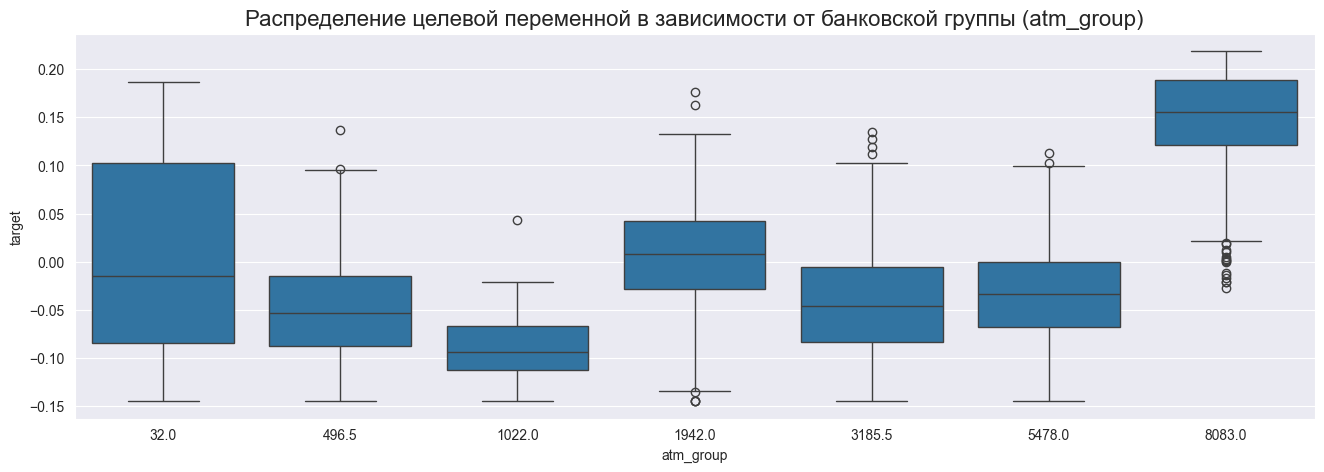

In [3]:
plt.figure(figsize= (16, 5))
plt.grid(True)
sns.boxplot(data= df, x='atm_group', y= "target")

plt.title("Распределение целевой переменной в зависимости от банковской группы (atm_group)", fontdict= {'fontsize': 16})
plt.show()

### 3. Анализ признаков второй группы: адреса банкоматов
Сформируем датафрейм с признаками группы и выполним его анализ

In [4]:
gr2_col_list = [
    'address', 
    'address_rus',
    'federal_district', 
    'region_with_type',
    'area_with_type', 
    'city_with_type',
    'city_area',
    'city_district_with_type',  
    'settlement_with_type', 
    'street_with_type', 
    'house'
]  
df2 = df[gr2_col_list]
df2.describe(include='all')

,address,address_rus,federal_district,region_with_type,area_with_type,city_with_type,city_area,city_district_with_type,settlement_with_type,street_with_type,house
count,6261,6261,6218,6218,845,5772,614,1925,524,6068,5673
unique,5343,4799,8,81,392,525,12,218,370,1975,663
top,"HOROSHEVSKOE SH,V38 MOSKVA","улица Ватутина, 107, Новосибирск, Россия, 630024",Центральный,г Москва,г Одинцово,г Москва,Центральный,Советский р-н,р-н Центральный,ул Ленина,1
freq,7,8,1777,641,22,538,157,142,17,255,246


Из результатов описания датасета видно, что: 
- все признаки данной группы - категориальные
- для признаков address и address_rus отсутствуют пропуски
- остальные признаки представляют собой разные компоненты адреса, начиная от федерального округа (federal_district) до дома (house)  

Нужно заметить, что компоненты адреса могут иметь пропуски, т.к. сама структура адреса не предполагает наличия всех компонентов (например, столицы регионов находятся вне муниципальных районов, в то время как города районного значения входят в них). Кроме того, для некоторых банкоматов адрес мог определиться не до уровня дома, а только до уровня улицы, города или даже региона. Учитывая это, можно сказать, что структура адреса была определена для 6218 записей из 6261, но не для всех с максимальной детализацией. Оставшиеся 43 записи, для которых не определен даже регион, скорее всего имеют ошибочные данные в полях address и(или) address_rus.

Поскольку количество уникальных значений для исследуемых признаков очень велико, использовать их в линейных моделях будет проблематично (за исключением федерального округа, для которого можно применить one hot encoding). Представляется, что признаки данной группы могут понадобиться либо для получения дополнительных числовых признаков из внешних источников, либо в моделях машинного обучения, позволяющих использовать категориальные признаки без дополнительного кодирования. 

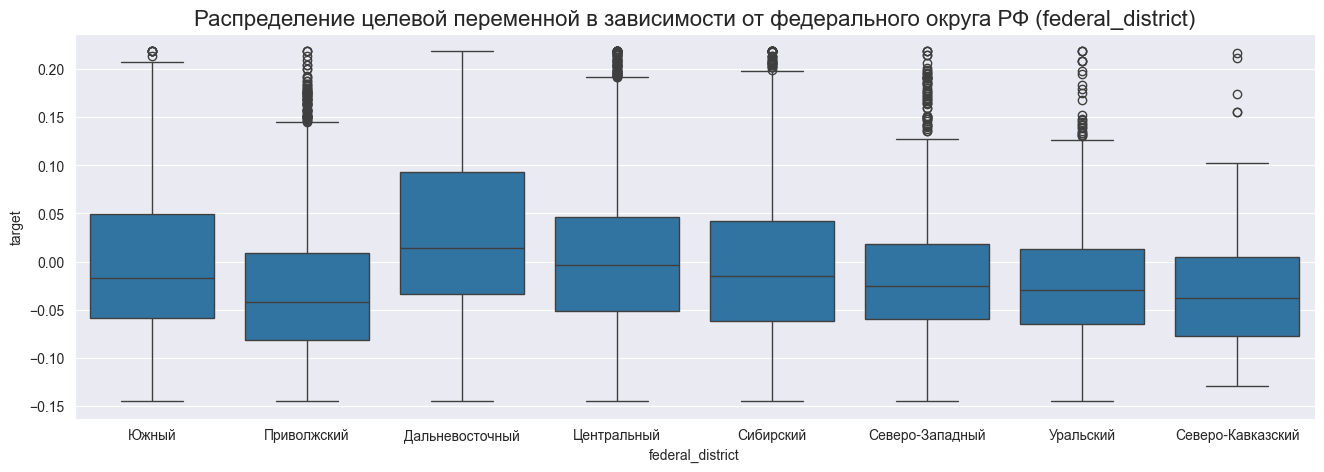

In [5]:
plt.figure(figsize= (16, 5))
plt.grid(True)
sns.boxplot(data=df, x='federal_district', y= "target")

plt.title("Распределение целевой переменной в зависимости от федерального округа РФ (federal_district)", fontdict= {'fontsize': 16})
plt.show()

### 4. Анализ признаков третьей группы: расстояния до ближайших станций метро и их параметры
Сформируем датафрейм с признаками группы и выполним его анализ

In [7]:
gr3_col_list = [
    'nearest_metro_distance', 
    'metro_station_name_1', 'metro_line_name_1', 'metro_distance_1', 
    'metro_station_name_2', 'metro_line_name_2', 'metro_distance_2', 
    'metro_station_name_3', 'metro_line_name_3', 'metro_distance_3'
]
df3 = df[gr3_col_list]
df3.describe(include='all')


,nearest_metro_distance,metro_station_name_1,metro_line_name_1,metro_distance_1,metro_station_name_2,metro_line_name_2,metro_distance_2,metro_station_name_3,metro_line_name_3,metro_distance_3
count,1223.000000,1130,1130,1130.000000,1114,1114,1114.000000,1093,1093,1093.000000
unique,NaN,270,32,NaN,254,32,NaN,248,31,NaN
top,NaN,Горьковская,Ленинская,NaN,Московская,Ленинская,NaN,Московская,Центральная,NaN
freq,NaN,30,87,NaN,36,88,NaN,51,79,NaN
mean,0.913491,NaN,NaN,0.933274,NaN,NaN,1.531598,NaN,NaN,2.029826
std,1.042339,NaN,NaN,1.060069,NaN,NaN,1.075859,NaN,NaN,1.147799
min,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.100000
25%,0.200000,NaN,NaN,0.200000,NaN,NaN,0.800000,NaN,NaN,1.200000
50%,0.500000,NaN,NaN,0.500000,NaN,NaN,1.200000,NaN,NaN,1.800000
75%,1.200000,NaN,NaN,1.200000,NaN,NaN,2.000000,NaN,NaN,2.700000


Из результатов описания видно, что данные о расстояниях до ближайшего метро и характеристиках соответствующих станций имеются только для 1223 банкоматов из 6261. Очевидно, что это связано с отсутствием метро в большинстве городов РФ. Также понятно, что заменить данныео метро для городов, где метро отсутствует не представляется возможным. В связи с этим использовать данные данной группы признаков в решении поставленной задачи мы не будем. 

Однако, посмотрим на зависимости между целевой переменной и числовыми признаками данной группы  

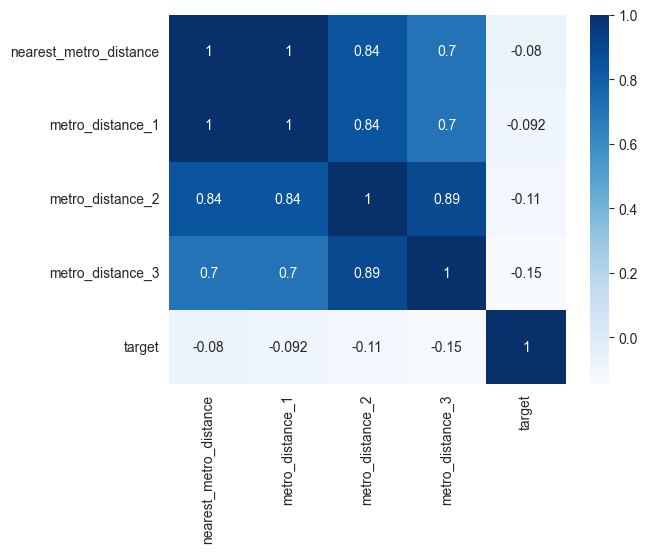

In [8]:
gr3_numeric_col_list = [
    'nearest_metro_distance',
     'metro_distance_1', 
    'metro_distance_2', 
    'metro_distance_3', 
    'target'
]
df4 = df[gr3_numeric_col_list]
corr = df4.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

Из результатов расчета коэффициентов корреляции видно, что целевая переменная не имеет сильной зависимости от признака nearest_metro_distance, хотя по сути именно он является здесь ключевым.

### 5. Заключение

По результатам выполненного анализа данных принято решение: 
- для обучения линейных моделей на следующем этапе проекта использовать следующие признаки: 
    - atm_group - банковская группа, которой принадлежит банкомат;
    - capital_marker - признак столицы региона или города федерального значения;
    - locality_area - площадь города, в котором расположен банкомат (в кв.км);
    - locality_population - население города, в котором расположен банкомат (количество человек);
    - target - целевая переменная, индекс популярности места для расположения банкомата;
- для заполнения пропусков и исправления аномальных значений признаков locality_area и locality_population попытаться доработать алгоритм получения этих данных из внешних источников. Оставшиеся после применения доработанного алгоритма пропуски и аномалии заменить на средние значения признаков по всей выборке или в рамках некоторого ее подмножества (например, средняя численность населения среди населенных пунктов одного региона);
- в связи с малыми значениями корреляции имеющихся признаков с целевой переменной - попытаться (в том числе, при наличии времени) дополнить датасет данными, характеризующими популярность места расположения банкомата (например, расстояние до ближайшего торгового центра, остановки общественного транспорта, школы и т.п.).  